# Notebook for Fixing Annotations - Do not run after 7/29/2024

## Load in the Packages

In [ ]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import os
import rapids_singlecell as rsc
import scvi # unneeded
import scvelo as scv
import palantir as pltr
from sklearn_ann.kneighbors.annoy import AnnoyTransformer  # currently unneeded
import math
import textwrap
import cellrank
from scipy import stats
import random

/home/johnathan/miniconda3/envs/sc_gpu_copy/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/johnathan/miniconda3/envs/sc_gpu_copy/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [ ]:
# Set the random seed
np.random.seed(42)
random.seed(42)

In [ ]:
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300)

scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 louvain==0.8.2 pynndescent==0.5.12


In [ ]:
import warnings
import logging

# Ignore all warnings
warnings.filterwarnings('ignore')

# Set logging level to ERROR to suppress info and warning messages
logging.getLogger().setLevel(logging.ERROR)

# Filter out the specific DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning, message="is_categorical_dtype is deprecated")

In [ ]:
input_dir = "/home/johnathan/projects/arrenkiel_scrnaseq/test/scrna/data/velocyto_cellbender_processed/analysis/"

output_dir = "/home/johnathan/projects/arrenkiel_scrnaseq/test/scrna/results"
cr_output_dir = os.path.join(output_dir, "cellrank", "figs")
os.makedirs(cr_output_dir, exist_ok = True)
cr_output_table_dir = os.path.join(output_dir, 'cellrank', 'table')
os.makedirs(cr_output_table_dir, exist_ok = True)

In [ ]:
# Process all screens
samples = [f'screen-{i}' for i in range(1, 5)]
# pull out gene list
aav = ['AAV1', 'AAV7', 'AAVDJ8', 'AAVRH10']

In [ ]:
kwargs = dict(frameon=False, size=10, linewidth=1.5,
              legend_loc = 'on data', legend_fontsize = 6
               , cmap = "Spectral_r")


In [ ]:
plot_kwargs = {'dpi':300, 'bbox_inches':'tight', 'facecolor':'white'}

In [ ]:
def chi_squared_test(a_probs, b_probs):
    # Ensure both arrays have the same length
    assert len(a_probs) == len(b_probs), "HBC and GBC probability arrays must have the same length"
    
    # Calculate chi-squared statistic
    chi2_stat = np.sum((a_probs - b_probs)**2 / b_probs)
    
    # Degrees of freedom
    df = len(a_probs) - 1
    
    # Calculate p-value
    p_value = 1 - stats.chi2.cdf(chi2_stat, df)
    
    return chi2_stat, df, p_value

## Load in object

In [ ]:
file_name = "fullobject_palantir_dpt.h5ad"

In [ ]:
ad = sc.read_h5ad(os.path.join(input_dir,file_name))

In [ ]:
# run some checks for the identity of this cluster
print(ad.obs.celltype.value_counts())
print(ad.obs.celltype_subs.value_counts())
print(ad.shape)
print(ad.raw.to_adata().shape)

celltype
mOSN      8970
mSus      3876
Mes       1859
BowG      1161
iOSN      1146
mOEC       441
ACC        403
RE         343
MVC        325
Gob        323
UnSec      288
iSus       265
Immune     233
VE         152
GBC        109
HBC         67
LE          61
SCC         59
Name: count, dtype: int64
celltype_subs
mOSN      8970
mSus      3392
Mes       1859
iOSN      1146
BowG      1125
mSus2      484
mOEC       441
ACC        403
RE         343
Gob        323
MVC        307
UnSec      288
iSus       265
Immune     233
VE         152
GBC        109
HBC         67
LE          61
SCC         59
BowG2       36
MVC2        18
Name: count, dtype: int64
(20081, 3000)
(20081, 24415)


## Load in genes of interest

In [ ]:
genes_of_interest = ['Ano2',
'Olfm1',
'Chga',
'Kcnk10',
'Cnga2',
'Sox11',
'Dpysl5', 'Dpysl2', 'Hdac',
'Lhx2',
'Ncam2']
olf_genes = ['Or6b2', 'Or6b2b', 'Or6b3', 'Or10j27', 'Or12k8']
osn_maturation_genes = ["Ascl1", "Neurog1", "Neurog2", "Tbx21", "Emx2", "Sox2", "Sox11", "Ngn1", "Lhx2", "Lhx9", "Ebf1", "Ebf2", "Mash1", "Otx2", "Gap43", "Neurod1", "Dlx5", "Dlx6", "Pax6", "Zic1", "Zic2", "Foxg1", "Irx3", "Bdnf", "Gdnf"
]
axon_targeting_genes= ["Reln", "Shh", "Wnt3a", "Dcx", "Nrg1", "Nrp1", "EphA4", "Bdnf", "Slit1", "Robo1", "Robo2", "PSA-NCAM", "Prok2", "Tbr2", "Sema3A", "Nrp2", "Gad1", "EphA5", "EphA6", "Efna5", "Ntn1", "Dcc", "Cdh1", "Cdh2", "Pcdh", "L1CAM",] 
axon_targeting_genes2= ["Tnr", "Cntn2", "Ctnnb1", "Sema7A", "Robo3", "Itga3", "Itgb1", "PlxnA1", "Robo1", "Robo2", "PSA-NCAM", "Cdk5", "Sema3C", "Dscam", "Lhx2", "Slitrk1", "Slitrk2", "Gfra1", "Lhx9", "Gli1", "Gli2", "Lrig1", "Erbb4", "Nrn1", "Slit3", "Bcl11b", "FOXP2", "Nrp2", "EphB2", "Atf5", "Axin2", "Nrp1", "Tnc", "Zic2", "Or2p2", "Or2ab1", "Or9e1", "Or2f1"
]
other_genes_of_interest = ["Nrp2", "PlxnA4", "NrCAM", "Fzd3", "Celsr3", "Dscam", "Slit2", "Sox11", "Gfra1", "Robo4", "Arhgap21", "Cux1", "Cux2", "Spinophilin", "Kalirin", "Neurod2", "Pcdh10", "Map2", "Shank3", "Dlg4", "Bdnf", "Camk2a", "Arpc3", "Mef2c", "Notch1", "Omp", "Gnai2", "Gucy1b2", "Adcy3", "Pax6", "Cyp2g1", "Slc8a1"
]

In [ ]:
ad

AnnData object with n_obs × n_vars = 20081 × 3000
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes', 'doublet_x', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden_0.1', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_3.5', 'celltype', 'leiden_5', 'leiden_10', 'leiden_6', 'doublet_y', 'singlet', 'prediction', 'leiden_8', 'palantir_pseudotime', 'palantir_entropy', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'celltype_subs'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'gene_trends_clusters'
    uns: 'DM_EigenValues', '_scvi_manager_uuid', '_scvi_uuid'

## Add original raw object back to AnnData object - Skip if after 7/31/2024

In [ ]:
ad_raw = sc.read_h5ad(os.path.join('/home/johnathan/projects/arrenkiel_scrnaseq/test/scrna/data/velocyto_cellbender_processed/after_qc/annotated', 'annotated_object_allgenes.h5ad'))

In [ ]:
ad.shape

(20081, 3000)

In [ ]:
ad.raw = ad_raw.copy()

In [ ]:
ad.raw.to_adata()

AnnData object with n_obs × n_vars = 20081 × 24415
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'n_genes', 'doublet_x', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden_0.1', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_3.5', 'celltype', 'leiden_5', 'leiden_10', 'leiden_6', 'doublet_y', 'singlet', 'prediction', 'leiden_8', 'palantir_pseudotime', 'palantir_entropy', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'DM_EigenValues', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'celltype_colors', 'ce

In [ ]:
markers.values()

dict_values(['Cdhr3', 'Muc5b', 'Agr2', 'Ascl3', 'Carmn', 'Mybl1', 'Sox11', 'Alx3', 'Olfm1', 'Muc2', 'Flt1', 'Trpm5', 'Hes6', 'Krt5', 'Cd74', 'Ccl21a', 'Bpifb4', 'Tmsb4x', 'Rrbp1', 'Bpifa1'])

## Fix the celltype annotations - Skip if running after 7/31/2024

In [ ]:
ad.obs['celltype_subs'] = ad.obs['celltype']

In [ ]:
new_categories = ['MVC2', 'BowG2']
ad.obs['celltype_subs'] = ad.obs.celltype_subs.cat.add_categories(new_categories)

In [ ]:
ad.obs.loc[ad.obs['celltype'] == 'isus', 'celltype'] = 'BowG'
ad.obs.loc[ad.obs['leiden_3'] == '60', 'celltype'] = 'MVC'

ad.obs.loc[ad.obs['leiden_3'] == '59', 'celltype_subs'] = 'BowG2'
ad.obs.loc[ad.obs['leiden_3'] == '60', 'celltype_subs'] = 'MVC2'

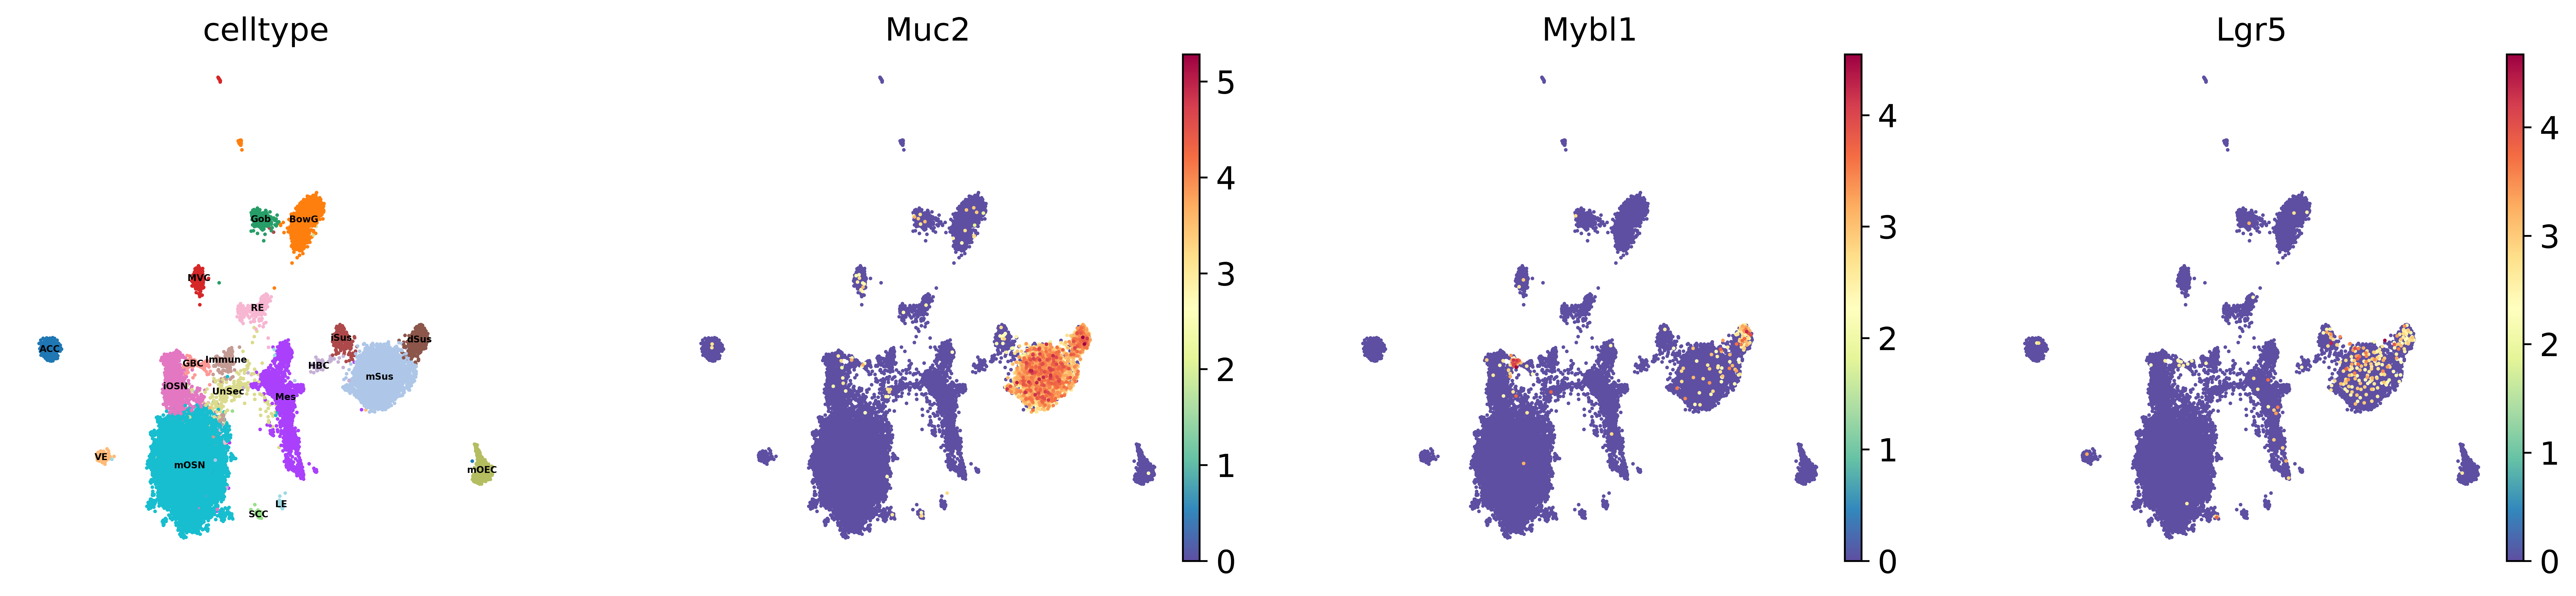

In [ ]:
sc.pl.umap(ad, color = ['celltype', 'Muc2', 'Mybl1', 'Lgr5'], **kwargs)

In [ ]:
with plt.rc_context({"figure.figsize": (12, 12), "figure.dpi": (300)}):
    sc.pl.umap(ad, color = ['celltype', 'Bpifb9b', 'Bpifb9a', 'Bpifb5',
                        'Trpm5', 'Ascl3',
                        'Obp2a', 'Obp2b'], **kwargs,
               ncols = 2)

In [ ]:
result = ad.uns['dealeiden_2']
groups = result['names'].dtype.names
markers = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']})
# Extract results for clusters 25 and 22
clusters_of_interest = ['40']

# Initialize an empty list to store the DataFrames for each cluster
selected_markers = []

# Loop through each cluster of interest and filter the DataFrame
for cluster in clusters_of_interest:
    cluster_df = markers.loc[:, [col for col in markers.columns if col.startswith(cluster + '_')]]
    selected_markers.append(cluster_df)

# Combine the DataFrames for the selected clusters
selected_markers_df = pd.concat(selected_markers, axis=1)

# Display the results
print(selected_markers_df.head(20))

             40_n       40_l          40_p
0           Obp2a  14.689249  2.557424e-09
1           Lcn11  13.263999  2.557424e-09
2          Clec2d   6.888774  1.417812e-08
3        BC051076  15.338214  1.417812e-08
4           Obp2b  14.118051  1.417812e-08
5            Mup4  13.889893  1.417812e-08
6         Gm14744  14.551053  1.417812e-08
7           Obp1b  13.783717  1.758788e-07
8           Obp1a  13.250147  1.758788e-07
9   5430401F13Rik  12.560097  1.758788e-07
10         Phlda1   7.991208  3.328209e-07
11  5430402E10Rik  14.346767  1.932595e-06
12          Rrbp1   4.932304  2.348216e-05
13          A2ml1   8.324205  2.754622e-05
14          Neat1   2.686927  7.435623e-05
15         Srsf10   4.940642  9.920458e-05
16         Gm6619  12.806189  1.354572e-03
17        Cyp2b19  11.639816  1.354572e-03
18         Galnt3   4.919067  2.275687e-03
19           Nktr   3.412356  5.649532e-03


In [ ]:
gene_exp = ad.raw.to_adata()[:, list(markers.values())].to_df()

# 4. Calculate mean expression per cell type
mean_exp = gene_exp.groupby(ad.obs['celltype']).mean()

# 5. Hierarchical clustering to order cell types and genes
cell_type_order = mean_exp.index[sns.clustermap(mean_exp).dendrogram_row.reordered_ind]
gene_order = mean_exp.columns[sns.clustermap(mean_exp.T).dendrogram_row.reordered_ind]

# 6. Reorder the data
mean_exp_ordered = mean_exp.loc[cell_type_order, gene_order]

# 7. Calculate fraction of cells expressing each gene
fraction_expressed = (gene_exp > 0).groupby(ad.obs['celltype']).mean()
fraction_expressed_ordered = fraction_expressed.loc[cell_type_order, gene_order]

# 8. Plot improved dot plot
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(mean_exp_ordered, cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Mean expression'})

# Overlay dots
for i, cell_type in enumerate(mean_exp_ordered.index):
    for j, gene in enumerate(mean_exp_ordered.columns):
        fraction = fraction_expressed_ordered.loc[cell_type, gene]
        ax.scatter(j + 0.5, i + 0.5, s=fraction * 500, color='black', alpha=0.5)

ax.set_xlabel('Genes')
ax.set_ylabel('Cell Types')
ax.set_title('Improved Dot Plot')
plt.tight_layout()
plt.show()

In [ ]:
sc.tl.rank_genes_groups(ad, 'celltype', method='wilcoxon')

# Get the top markers for each group
marker_dict = {}
for group in ad.obs['celltype'].unique():
    markers = sc.get.rank_genes_groups_df(ad, group=group, key='rank_genes_groups')
    top_markers = markers.head(30)['names'].tolist()  # Get top 5 markers
    marker_dict[group] = top_markers

# Convert to a DataFrame for easier viewing
marker_df = pd.DataFrame.from_dict(marker_dict, orient='index')
marker_df.columns = [f'Marker_{i+1}' for i in range(30)]

# Display the marker table
print(marker_df)

       Marker_1 Marker_2 Marker_3  Marker_4 Marker_5 Marker_6   Marker_7  \
MV2       Rrbp1    Neat1  Bpifb9b    Phlda1   Wfdc18  Bpifb9a       Nktr   
BowG       Vmo1     Ldhd    Muc5b   Slc38a2     Aox2    Chil6       Fmo5   
ACC      Dnah12   Ccdc17    Dnah3    Cfap43    Rgs22    Dnah6     Spag17   
mOEC       Apoe     Aatk   Atp1a2      Scd2  Col11a1     Plp1      Cldn5   
mSus    Sec14l3     Cbr2     Aox2    Cyp2g1     Muc2   Abca13        Por   
GBC       Top2a   Ccp110     Nasp      Hes6     Knl1    Mki67      Epcam   
iOSN       Ebf1    Sox11    Fstl5     Cpsf6    Map1b    Celf3      Ncam1   
Mes       Cald1     Tpm1   Zbtb20    Malat1     Flna    Ptprd     Col1a2   
RE      Scgb1c1   Bpifb4     Gpx6      Vmo1  Selenom    Cdcp3      Ces1d   
UnSec    Tmsb4x     Fth1  Scgb1c1      Tpt1    Calm1     Actb  Rn18s-rs5   
mOSN      Fstl5     Ahi1    Tshz2    Cfap69    Epha5    Cntn4      Nrxn1   
dSus    Sult1c1  Sec14l3     Aox2    Cyp2g1   Abca13      Por       Muc2   
iSus     Bpi

In [ ]:
marker_df.loc['MV2']

Marker_1             Rrbp1
Marker_2             Neat1
Marker_3           Bpifb9b
Marker_4            Phlda1
Marker_5            Wfdc18
Marker_6           Bpifb9a
Marker_7              Nktr
Marker_8            Bpifb5
Marker_9             Rsrp1
Marker_10            Meis2
Marker_11    E530011L22Rik
Marker_12    2310003L06Rik
Marker_13           Clec2d
Marker_14        Rn18s-rs5
Marker_15           Galnt7
Marker_16             Odam
Marker_17            Obp2a
Marker_18            Lcn11
Marker_19             Tcim
Marker_20          Elapor1
Marker_21    5430401F13Rik
Marker_22          Snrnp70
Marker_23           Srsf10
Marker_24            Gfpt1
Marker_25          Scgb1c1
Marker_26             Xbp1
Marker_27            Srsf5
Marker_28          Hnrnpa3
Marker_29         BC006965
Marker_30            Derl3
Name: MV2, dtype: object

In [ ]:
marker_df.loc['MV2']

Marker_1             Rrbp1
Marker_2             Neat1
Marker_3           Bpifb9b
Marker_4            Phlda1
Marker_5            Wfdc18
Marker_6           Bpifb9a
Marker_7              Nktr
Marker_8            Bpifb5
Marker_9             Rsrp1
Marker_10            Meis2
Marker_11    E530011L22Rik
Marker_12    2310003L06Rik
Marker_13           Clec2d
Marker_14        Rn18s-rs5
Marker_15           Galnt7
Marker_16             Odam
Marker_17            Obp2a
Marker_18            Lcn11
Marker_19             Tcim
Marker_20          Elapor1
Marker_21    5430401F13Rik
Marker_22          Snrnp70
Marker_23           Srsf10
Marker_24            Gfpt1
Marker_25          Scgb1c1
Marker_26             Xbp1
Marker_27            Srsf5
Marker_28          Hnrnpa3
Marker_29         BC006965
Marker_30            Derl3
Name: MV2, dtype: object

In [ ]:
marker_df.loc['dSus']

Marker_1      Sult1c1
Marker_2      Sec14l3
Marker_3         Aox2
Marker_4       Cyp2g1
Marker_5       Abca13
Marker_6          Por
Marker_7         Muc2
Marker_8         Ggt7
Marker_9         Cbr2
Marker_10      Papss2
Marker_11    Slc16a11
Marker_12       Neat1
Marker_13        Fmo6
Marker_14       Abcc5
Marker_15        Eya4
Marker_16        Ddx5
Marker_17      Pla2r1
Marker_18        Mapt
Marker_19    Slc25a35
Marker_20        Tcim
Marker_21      Cyp2a5
Marker_22     Gm43670
Marker_23     Sec14l2
Marker_24      Slc4a7
Marker_25       Hmcn1
Marker_26       Tyro3
Marker_27       Lima1
Marker_28     Slc27a2
Marker_29     Slc35d1
Marker_30        Pon1
Name: dSus, dtype: object

In [ ]:
marker_df.loc['iSus']

Marker_1            Bpifa1
Marker_2             Reg3g
Marker_3              Cbr2
Marker_4             Epas1
Marker_5              Sat1
Marker_6             Muc16
Marker_7              Vmp1
Marker_8             Neat1
Marker_9             H2-K1
Marker_10            Meis2
Marker_11            Prdx6
Marker_12    2010007H06Rik
Marker_13           Cyp2f2
Marker_14              Por
Marker_15             Has2
Marker_16        Serpinb11
Marker_17          Atp13a5
Marker_18          Zfp36l1
Marker_19           Igfbp5
Marker_20         Cyp4a12b
Marker_21            Wfdc2
Marker_22            Rrbp1
Marker_23             Ddx5
Marker_24           Malat1
Marker_25          Sec14l3
Marker_26             Chd3
Marker_27            Srsf5
Marker_28             AAV1
Marker_29            Tcf25
Marker_30             Cd55
Name: iSus, dtype: object

In [ ]:
marker_df.loc['GBC']

Marker_1         Top2a
Marker_2        Ccp110
Marker_3          Nasp
Marker_4          Hes6
Marker_5          Knl1
Marker_6         Mki67
Marker_7         Epcam
Marker_8         Sox11
Marker_9         Mybl1
Marker_10        Hmgb2
Marker_11        Psip1
Marker_12        Atad2
Marker_13        Cenpf
Marker_14         Gas5
Marker_15        Hells
Marker_16       Cep152
Marker_17       Ncapd3
Marker_18        Taf15
Marker_19         Prc1
Marker_20    Hnrnpa2b1
Marker_21          Kit
Marker_22         Gad2
Marker_23         Ebf1
Marker_24          Ncl
Marker_25         Tcf4
Marker_26         Hdgf
Marker_27      Hsp90b1
Marker_28        Rbm24
Marker_29         Ezh2
Marker_30       Hnrnpu
Name: GBC, dtype: object

In [ ]:
ad.obs['celltype_subs'] = ad.obs['celltype']

In [ ]:
new_categories = ['MVC2', 'BowG2']
ad.obs['celltype_subs'] = ad.obs.celltype_subs.cat.add_categories(new_categories)

In [ ]:
ad.obs.loc[ad.obs['celltype'] == 'MV2', 'celltype'] = 'BowG'
ad.obs.loc[ad.obs['leiden_3'] == '60', 'celltype'] = 'MVC'

ad.obs.loc[ad.obs['leiden_3'] == '59', 'celltype_subs'] = 'BowG2'
ad.obs.loc[ad.obs['leiden_3'] == '60', 'celltype_subs'] = 'MVC2'

In [ ]:
# repeat the process for dSus 
# the evidence is far too weak
ad.obs['celltype_subs'] = ad.obs.celltype_subs.cat.add_categories(['mSus2'])
ad.obs.loc[ad.obs['celltype'] == 'dSus', 'celltype'] = 'mSus'
ad.obs.loc[ad.obs['celltype_subs'] == 'dSus', 'celltype_subs'] = 'mSus2'

In [ ]:
# drop the unused categories
ad.obs['celltype'] = ad.obs['celltype'].cat.remove_unused_categories()
ad.obs['celltype_subs'] = ad.obs['celltype_subs'].cat.remove_unused_categories()

In [ ]:
# save the corrected cell types and new "subcluster" annotations
ad.write_h5ad(os.path.join(input_dir, file_name))